<!-- General condition: The stock price is above its 200 day Moving average
    
Buy decision if:
    19 period RSI of the stock is below 30
    ==>> Buy on the next day open

Sell decision if:
    19-period RSI is above 40 or after 20 trading days
    ==>> Sell on next day open -->

# General condition: The stock price is above its 200-day Moving average
    
#     Buy decision if: 19 period RSI of the stock is below 30
#         ==>> buy on next day open
    
#     Sell decision if:

#         19_period RSI is above 40 or after 10 trading days
#         ==>> sell on next day open
        

# (BITCOIN)
        
    
        

In [1]:
import pandas as pd
import numpy as np
from binance.client import Client
from binance import BinanceSocketManager
from binance.enums import*
from binance.exceptions import BinanceAPIException, BinanceOrderException
import time
import os
#client.get_historical_klines('BTCUSDT','1m','30 m ago UTC')
api_key=os.environ.get('binance_api')
api_secret=os.environ.get('binance_secret')



client=Client(api_key,api_secret)
bsm=BinanceSocketManager(client)
socket=bsm.trade_socket('BTCUSDT')
await socket.__aenter__()
msg=await socket.recv()
#print(api_key,api_secret)


In [2]:
def getmindata(symbol, interval, start):
    frame=pd.DataFrame(client.get_historical_klines(symbol, interval, start))
    frame=frame.iloc[:,:6]
    frame.columns=['opentime',"open",'high','low','close','volume']
    frame=frame.set_index('opentime')
    frame.index=pd.to_datetime(frame.index, unit='ms')
  
   # frame.closetime=pd.to_datetime(frame.closetime, unit='ms')
    frame=frame.astype(float)    
    frame.reset_index(inplace=True)        
    return frame

In [3]:
df=getmindata('BTCUSDT','1d','2 year ago UTC')
df

,opentime,open,high,low,close,volume
0,2019-11-13,8821.91,8844.99,8702.00,8777.12,26810.116918
1,2019-11-14,8777.54,8800.00,8582.60,8646.68,33468.468961
2,2019-11-15,8646.38,8790.00,8400.00,8471.73,46087.417751
3,2019-11-16,8471.62,8543.00,8400.00,8491.02,20902.299752
4,2019-11-17,8490.74,8635.00,8350.68,8502.40,27009.037082
...,...,...,...,...,...,...
726,2021-11-08,63273.58,67789.00,63273.58,67525.83,54442.094554
727,2021-11-09,67525.82,68524.25,66222.40,66947.66,44661.378068
728,2021-11-10,66947.67,69000.00,62822.90,64882.43,65171.504046
729,2021-11-11,64882.42,65600.07,64100.00,64774.26,37237.980580


In [4]:
df['MA200']=df['close'].rolling(window=200).mean()


In [5]:
df=df.dropna()
pd.options.mode.chained_assignment=None

In [6]:
df['price change']=df['close'].pct_change()


In [7]:
df=df.dropna()


In [8]:
df['upmove']=df['price change'].apply(lambda x:x if x>0 else 0)
df['downmove']=df['price change'].apply(lambda x:x if x<0 else 0)
df['avg up']=df['upmove'].ewm(span=19).mean()
df['avg down']=df['downmove'].ewm(span=19).mean()

In [9]:
df=df.dropna()


In [10]:
df['RSI']=df['avg up']/df['avg down']
df['RSI']=df['RSI'].apply(lambda x: 100-(100/(x+1)))


In [11]:
df.loc[(df['close']>df['MA200']) & (df['RSI']<30), 'BUY']=1
df.loc[(df['close']<df['MA200']) | (df['RSI']>30), 'BUY']=0
df

,opentime,open,high,low,close,volume,MA200,price change,upmove,downmove,avg up,avg down,RSI,BUY
200,2020-05-31,9697.72,9700.00,9381.41,9448.27,48333.786403,8059.18105,-0.025723,0.000000,-0.025723,0.000000,-0.025723,0.000000,1.0
201,2020-06-01,9448.27,10380.00,9421.67,10200.77,76649.126960,8066.95150,0.079644,0.079644,0.000000,0.041918,-0.012184,140.978367,0.0
202,2020-06-02,10202.71,10228.99,9266.00,9518.04,108970.773151,8072.18305,-0.066929,0.000000,-0.066929,0.026450,-0.032385,-445.638734,1.0
203,2020-06-03,9518.02,9690.00,9365.21,9666.24,46252.644939,8078.05915,0.015570,0.015570,0.000000,0.023286,-0.022968,7318.959764,0.0
204,2020-06-04,9666.32,9881.63,9450.00,9789.06,57456.100969,8084.49245,0.012706,0.012706,0.000000,0.020703,-0.017360,619.247050,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,2021-11-08,63273.58,67789.00,63273.58,67525.83,54442.094554,45483.05040,0.067204,0.067204,0.000000,0.018219,-0.007427,168.826328,0.0
727,2021-11-09,67525.82,68524.25,66222.40,66947.66,44661.378068,45562.16300,-0.008562,0.000000,-0.008562,0.016397,-0.007541,185.148702,0.0
728,2021-11-10,66947.67,69000.00,62822.90,64882.43,65171.504046,45636.33595,-0.030848,0.000000,-0.030848,0.014757,-0.009872,302.053315,0.0
729,2021-11-11,64882.42,65600.07,64100.00,64774.26,37237.980580,45714.87340,-0.001667,0.000000,-0.001667,0.013282,-0.009051,313.957111,0.0


In [27]:

i=0
money=100

ds=pd.DataFrame()






while i<len(df):
    ##LONG STRATEGY
    if (df.iloc[i,13]==1):
        
   
       
        a=i+1
       
      
        while a<len(df):

            if (df.iloc[a,12]>=40) | (a-i==10):
                profit=((df.iloc[a+1,1]-df.iloc[i+1,1])/df.iloc[i+1,1])
                money=money+money*profit
                ds=ds.append({"buy_time":df.iloc[i+1,0],"buy_price":df.iloc[i+1,1],'sell_time'\
                :df.iloc[a+1,0],'sell_price':df.iloc[a+1,1],'profit%':profit,'money':money,}, ignore_index=True)
                
                i=a+1                  
                break

            else:

                a=a+1
        i=a+1
         
       
     
   
    else:
    
        i=i+1
                            

            
print(ds)
print(f'net profit%={money-100}%')


     buy_time  buy_price  sell_time  sell_price   profit%       money
0  2020-06-01    9448.27 2020-06-02    10202.71  0.079850  107.984954
1  2020-06-03    9518.02 2020-06-04     9666.32  0.015581  109.667464
2  2020-06-06    9621.17 2020-06-07     9666.85  0.004748  110.188150
3  2020-06-12    9278.88 2020-06-22     9294.69  0.001704  110.375897
4  2020-06-25    9298.33 2020-07-05     9135.00 -0.017566  108.437087
5  2020-07-06    9069.41 2020-07-07     9342.47  0.030108  111.701889
6  2020-07-10    9232.42 2020-07-11     9288.34  0.006057  112.378458
7  2020-07-12    9234.02 2020-07-13     9303.31  0.007504  113.221721
8  2020-07-14    9242.61 2020-07-22     9390.00  0.015947  115.027244
9  2020-08-26   11318.42 2020-08-29    11526.90  0.018420  117.145992
10 2020-08-30   11465.84 2020-08-31    11711.17  0.021397  119.652518
11 2020-09-03   11388.54 2020-09-13    10440.67 -0.083230  109.693820
12 2020-09-14   10332.84 2020-09-15    10671.77  0.032801  113.291914
13 2020-09-22   1041

In [28]:
#WIN RATIO
wins=[i for i in ds['profit%'] if i>0]
wins
len(wins)/len(ds)



0.8571428571428571

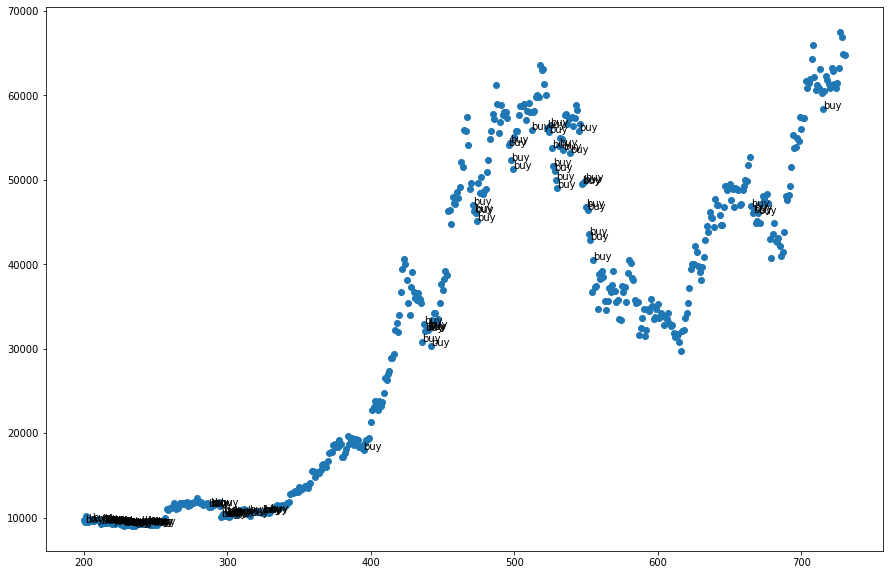

In [29]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
plt.scatter(df.index,df['open'])
for i in range(0,len(df)):
    
    if df.iloc[i,13]==1:
        
        plt.annotate('buy',(i+201,df.iloc[i+1,1]))
plt.show()